# Goals

Inputs
- dataset and an experiment ID
- this will then read the correct CSV vom ${LOGS_THIRD}_test_csv
- some crop image ID + coords

Output
- table with bpsps
- crop figure for that input

In [1]:
import os
from test_dataset_parser import name_from_images, parse_into_datasets
from test import multiscale_tester
import pandas as pd
import glob
import base64
from PIL import Image
from IPython.display import HTML, display
from dataloaders import cached_listdir_imgs
from helpers import imgstats
from collections import namedtuple
import numpy as np
from matplotlib import pyplot as plt
import functools
import re
pd.set_option('display.max_colwidth', -1)  
%matplotlib inline

from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)


WRAN: using Agg backend linux
***No CUDA syncs for timings


In [2]:
# RESOURCE
import subprocess
envs = subprocess.check_output('bash -c "source ~/.shared_rc; env"', shell=True).decode()
for l in envs.split('\n'):
    if l.count('=') == 1:
        key, value = l.strip().split('=')
        if key.startswith('_'):
            continue
#         print('Setting', key)
        os.environ[key] = value

In [3]:
# INPUTS

FIGS_PAPER = os.path.expanduser('~/figs_paper')
os.makedirs(FIGS_PAPER, exist_ok=True)

CSV_LOG_DIR = os.environ['LOGS_THIRD'] + '_test_csv'
DATASET = os.environ['T_VAL_OIR_500_M']
# DATASET = os.environ['T_DIV_CROP_M']
print(DATASET)
EXPERIMENT = '1108_2150.437250'

NOISE_DIR = 'samples_tau/1108_2150/'
# NOISE_EX = '0806_0'
# NOISE_DIM = 156
# NOISE_LOC = (80, 600)
NOISE_EX = '0843_0'
NOISE_DIM = 320
NOISE_LOC = (400, 800)
OTP = os.path.join(FIGS_PAPER, 'sampling', EXPERIMENT.replace('.', '_'))
os.makedirs(OTP, exist_ok=True)

# brige
NOISE_DIR = 'samples_tau_clic/1108_2150/'
NOISE_EX = 'vita-vilcina-3055_2'
NOISE_DIM = 300
# from top?
NOISE_LOC = (400, 300)

# sky
NOISE_DIR = 'samples_tau_clic/1108_2150/'
NOISE_EX = 'stefan-kunze-26931_2'
NOISE_DIM = 300
# from top?
NOISE_LOC = (400, 300)



def _save_fig(fig, sub_p, show=False):
    p = os.path.join(FIGS_PAPER, sub_p)
    print('Saving', p)
    fig.savefig(p, bbox_inches='tight')
    if show:
        display(Image.open(p))

def _save_ax(ax, sub_p):
    _save_fig(ax.get_figure(), sub_p)

/home/mentzerf/net_scratch/datasets/openimages_rand/val_oi_500_r_multi_q9_10_11_12_13_14_15_16_17


In [4]:
dataset_p, compressed_name = name_from_images(DATASET)
dataset_name = os.path.basename(dataset_p)

baselines_csv_dir = os.path.join(CSV_LOG_DIR, dataset_name)
# expected this to exists and contain the baselines
assert os.path.isdir(baselines_csv_dir), baselines_csv_dir  

ours_csv_dir = os.path.join(CSV_LOG_DIR, compressed_name)
# expected this to exists and contain some CSV files of the form 1105_2000.393750.csv
assert os.path.isdir(ours_csv_dir), ours_csv_dir  

ours_csv = os.path.join(ours_csv_dir, EXPERIMENT)
if not EXPERIMENT.endswith('.csv'):
    ours_csv += '.csv'

assert os.path.isfile(ours_csv), ours_csv

In [5]:

def _crop_im_or_np(i, dim, loc):
    if isinstance(i, np.ndarray):
        i = i[0, ...]
        _, h, w = i.shape
    else:
        w, h = i.size
    y, x = loc
    assert 0 <= x < w and 0 <= y < h
    assert x >= dim // 2 and y >= dim//2
    left = x - dim // 2
    upper = y - dim // 2
    right = left + dim
    lower = upper + dim
    if isinstance(i, np.ndarray):
        i = i[:, upper:lower,left:right]
        if len(i.shape) == 3:
            i = np.transpose(i, (1,2,0))
        return i
    else:
        return i.crop((left, upper, right, lower))

Min -9 // Max 9
/home/mentzerf/figs_paper/sampling/1108_2150_437250 bridge raw


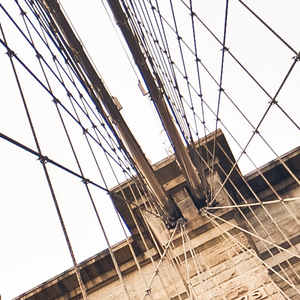

/home/mentzerf/figs_paper/sampling/1108_2150_437250 bridge sample0


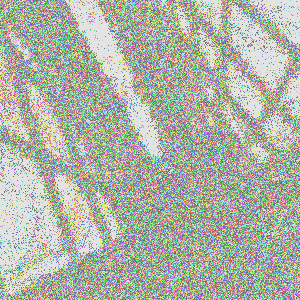

/home/mentzerf/figs_paper/sampling/1108_2150_437250 bridge sample1


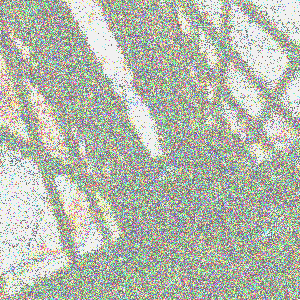

/home/mentzerf/figs_paper/sampling/1108_2150_437250 bridge sample2


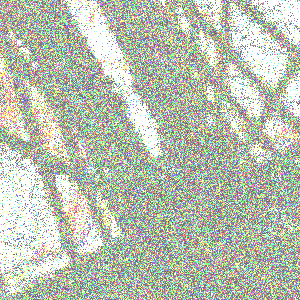

/home/mentzerf/figs_paper/sampling/1108_2150_437250 bridge bpg


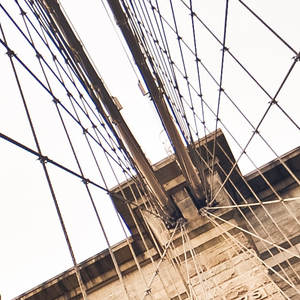

/home/mentzerf/figs_paper/sampling/1108_2150_437250 bridge gt


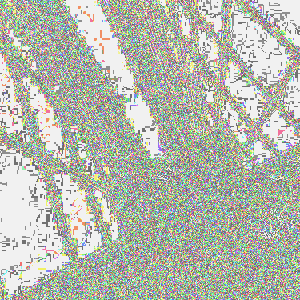

Min -5 // Max 4
/home/mentzerf/figs_paper/sampling/1108_2150_437250 sky raw


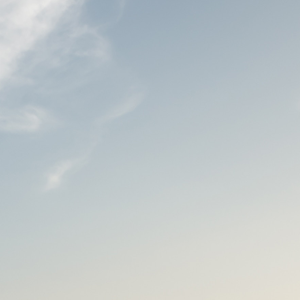

/home/mentzerf/figs_paper/sampling/1108_2150_437250 sky sample0


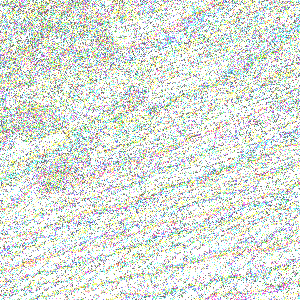

/home/mentzerf/figs_paper/sampling/1108_2150_437250 sky sample1


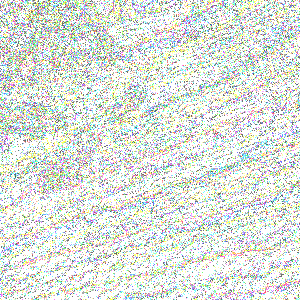

/home/mentzerf/figs_paper/sampling/1108_2150_437250 sky sample2


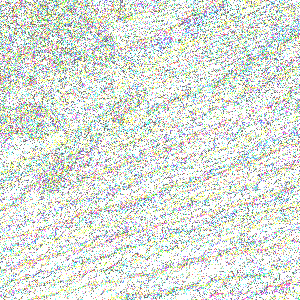

/home/mentzerf/figs_paper/sampling/1108_2150_437250 sky bpg


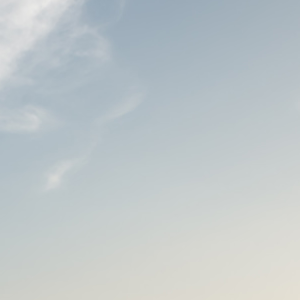

/home/mentzerf/figs_paper/sampling/1108_2150_437250 sky gt


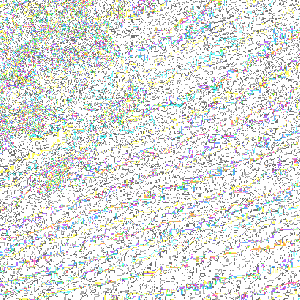

In [6]:
assert os.path.isdir(NOISE_DIR)

NoiseSpec = namedtuple('NoiseSpec', ['d', 'ex', 'dim', 'loc', 'name'])


# # brige
# NOISE_DIR = 'samples_tau_clic/1108_2150/'
# NOISE_EX = 'vita-vilcina-3055_2'
# NOISE_DIM = 300
# # from top?
# NOISE_LOC = (400, 300)

# # sky
# NOISE_DIR = 'samples_tau_clic/1108_2150/'
# NOISE_EX = 'stefan-kunze-26931_2'
# NOISE_DIM = 300
# # from top?
# NOISE_LOC = (400, 300)

for d, ex, dim, loc, unique_id in [
    ('samples_tau_clic/1108_2150/', 'vita-vilcina-3055_2', 300, (400, 300), 'bridge'),
    ('samples_tau_clic/1108_2150/', 'stefan-kunze-26931_2', 300, (400, 300), 'sky')]:
    ps = sorted(glob.glob(os.path.join(d, '*' + ex + '*')))
    assert len(ps) > 0

    # get mi, ma, for equal normalization
    mi, ma = 0, 0
    for p in ps:
        if p.endswith('.npy'):
            i = _crop_im_or_np(np.load(p), dim, loc)
            mi = min(mi, np.amin(i))
            ma = max(ma, np.amax(i))

    print('Min', mi, '//', 'Max', ma)

    def display_and_save(i, name):
        print(OTP, unique_id, name)
        display(i)
        i.save(os.path.join(OTP, f'{unique_id}_{name}.png'))

    for p in ps:
        m = re.search(r'\d\.\d\d\d_(.*?)\.(npy|png)', p)
        if not m:
            raise ValueError(p)
        name = m.group(1)
        if p.endswith('.npy'):
            i = _crop_im_or_np(np.load(p), dim, loc)
            i[i==0] = np.amax(i)  # set gray to white
            i = i.astype(np.float32)
            i -= mi
            i /= (ma - mi)
            i *= 255.
            i = i.round().astype(np.uint8)
            display_and_save(Image.fromarray(i), name)
        elif 'gt' not in p and 'sample0.png' not in p:
            display_and_save(_crop_im_or_np(Image.open(p), dim, loc), name)

In [7]:
ds = list(parse_into_datasets(DATASET))[0]

Getting lock for /home/mentzerf/net_scratch/datasets/openimages_rand/val_oi_500_r/cached_glob.pkl: .cached_glob.lock [reset: False]...
>>> filter [min_size=None; discard_s=False]: 0.00405
Getting lock for /home/mentzerf/net_scratch/datasets/openimages_rand/val_oi_500_r_bpg_q9/cached_glob.pkl: .cached_glob.lock [reset: False]...
>>> filter [min_size=None; discard_s=False]: 0.00320
Sorting...
Getting lock for /home/mentzerf/net_scratch/datasets/openimages_rand/val_oi_500_r/cached_glob.pkl: .cached_glob.lock [reset: False]...
>>> filter [min_size=None; discard_s=False]: 0.00257
Getting lock for /home/mentzerf/net_scratch/datasets/openimages_rand/val_oi_500_r_bpg_q10/cached_glob.pkl: .cached_glob.lock [reset: False]...
>>> filter [min_size=None; discard_s=False]: 0.00355
Sorting...
Getting lock for /home/mentzerf/net_scratch/datasets/openimages_rand/val_oi_500_r/cached_glob.pkl: .cached_glob.lock [reset: False]...
>>> filter [min_size=None; discard_s=False]: 0.00209
Getting lock for /home/

In [8]:
baselines_glob = os.path.join(baselines_csv_dir, '*.csv')
baselines_csvs = sorted(glob.glob(baselines_glob))
assert baselines_csvs, baselines_glob

df_classical = pd.DataFrame()
images = None
for p in baselines_csvs:
    name =  os.path.splitext(os.path.basename(p))[0]
    df = pd.read_csv(p)
#     print(df.head())
    if 'image' not in df_classical:
        df_classical['image'] = df['image']
        images = list(df['image'])
    else:
        assert list(df['image']) == images
    df_classical[name.upper()] = df['bpsp']
    
# df_classical = [(os.pathpd.read_csv, baselines_csvs))

display(df_classical)

,image,FLIF,PNG
0,0001eeaf4aed83f9,2.507318,3.443056
1,00723dac8201a83e,3.465585,4.255317
2,00ec74f564bd4425,3.644481,4.778213
3,016d30e2c65de0d7,3.246853,4.459995
4,01f5efed4dfda77e,3.910645,4.938428
...,...,...,...
495,fdec7849a0a64567,3.046624,4.259745
496,fe6139d150a3e2a8,2.259047,3.622125
497,fef54ede1354f96b,2.889348,4.326867
498,ff6a1749f647aa98,2.908223,3.829380


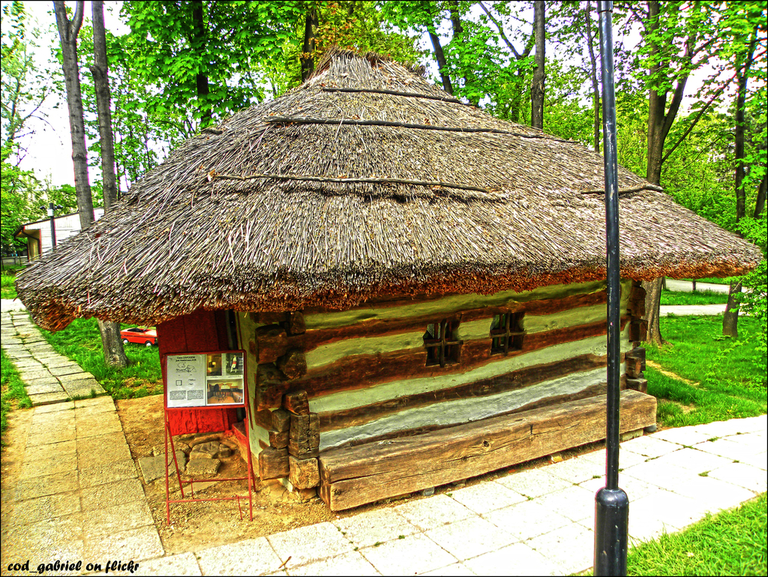

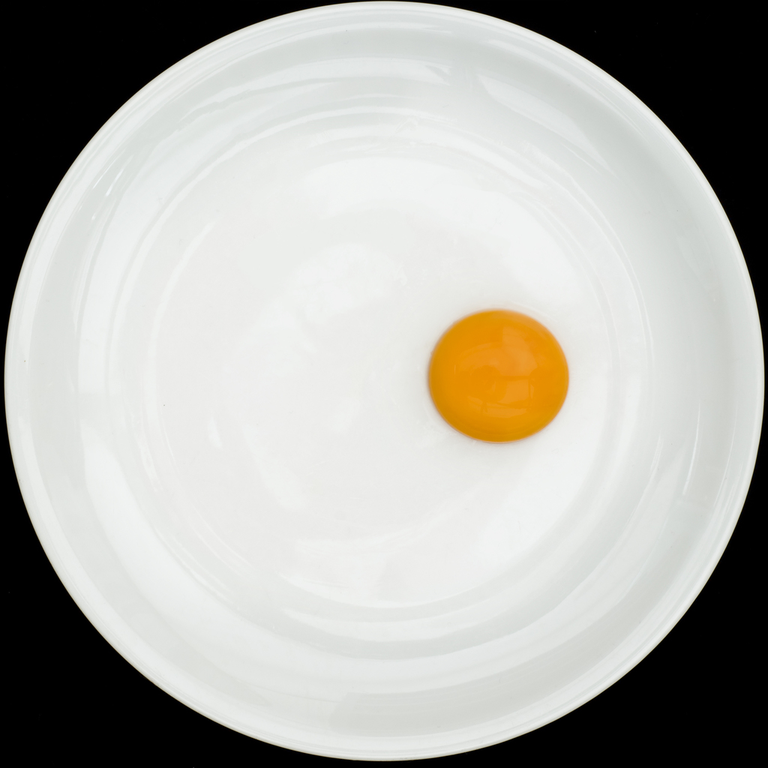

,image,Ours,Q,BPG
0,0001eeaf4aed83f9,2.538002,13,0.862273
1,00723dac8201a83e,3.527122,15,1.260767
2,00ec74f564bd4425,3.448106,14,1.708883
3,016d30e2c65de0d7,3.176750,14,1.340800
4,01f5efed4dfda77e,4.021191,15,1.725840
...,...,...,...,...
495,fdec7849a0a64567,2.992795,14,1.323187
496,fe6139d150a3e2a8,2.056147,13,0.958307
497,fef54ede1354f96b,2.694703,14,1.162067
498,ff6a1749f647aa98,2.909148,14,1.001113


In [9]:
OURS_COLUMN = 'Ours'

df_ours = pd.read_csv(ours_csv)

df_ours = df_ours.rename(columns={'bpsp': OURS_COLUMN})

fn_Qs = [(fn, Q) for _, (fn, _, Q) in df_ours.iterrows()]
# fn_13 = [(fn, 13) for _, (fn, _, _) in df_ours.iterrows()]

_, max_idx = max(ds.some_dataset._iter_bpp_idx())
# max_img, max_img_Q = next((fn, Q) for fn, Q in fn_Qs if fn == ds.get_filename(max_idx))
_, min_idx = min(ds.some_dataset._iter_bpp_idx())
# min_img, min_img_Q = next((fn, Q) for fn, Q in fn_Qs if fn == ds.get_filename(min_idx))

# print(ds.get_raw_p(max_idx))
display(Image.open(ds.get_raw_p(max_idx)))
display(Image.open(ds.get_raw_p(min_idx)))

bpsp_bpg = ds.get_bpg_bpsps(fn_Qs)
# fixed_Qs_bpg = ds.get_bpg_bpsps(fn_13)
df_ours['BPG'] = bpsp_bpg
# df_ours['BPG_Q13'] = fixed_Qs_bpg

display(df_ours)

assert list(df_ours['image']) == list(df_classical['image'])

In [10]:
histos = imgstats.avg_histo(ds.iter_residuals(fn_Qs), stop=10)

NameError: name 's' is not defined

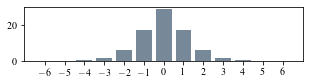

In [11]:

combined_histo = functools.reduce(np.add, histos)

fig = plt.figure(figsize=(5,1))
xs, ys = imgstats.truncate_histo(combined_histo, min_val=1e-2)
plt.bar(xs,ys, color='#778899')
plt.xticks(xs)
plt.style.use(s)
ax = fig.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_ticks([])
_save_fig(fig, 'bpg_oi_histo.pdf')

    # for c, histo in enumerate(histos):


In [ ]:
import matplotlib.ticker as mtick
from matplotlib import gridspec
from matplotlib.patches import Polygon

df_final = df_classical
final_cols = (OURS_COLUMN, 'Q', 'BPG')
for merger in final_cols:
    df_final[merger] = df_ours[merger]
    
bpsp_df = df_final[[OURS_COLUMN, 'FLIF', 'BPG', 'PNG']] #, 'png']]

# fig, axs = plt.subplots(ncols=1, nrows=2, gridspec_kw={'height_ratios': [4, 1]}, figsize=(24,5.8))
# print(axs)
# fig.set_size_inches(18.5, 10.5)

fig = plt.figure(figsize=(6,4.8), dpi=300) 
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1],hspace=0.05) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
axs = [ax0, ax1]

rename = {'BPG': '$x_l$ only'}
order = {'Ours': 0, 'BPG': 1, 'FLIF':2, 'PNG':3}
#'#BA7171'
colors ={'Ours': '#C14B4B', 'BPG': '#D89191', 'FLIF':'#64A2B7', 'PNG':'#0BA85C'}
bpsp_df = bpsp_df.sort_values(OURS_COLUMN).reset_index(drop=True)
bpsp_df.index += 1 
ax = bpsp_df.plot(style=['-', '-', '-', '-'], ax=axs[0])  # figsize=(6,4), 
lines, labels = ax.get_legend_handles_labels()
lines_labels = []
for l, label in zip(lines, labels):
    l.set_color(colors[label])
    if label == 'Ours':
        l.set_zorder(20)
        l.set_linewidth(2)
    if label == 'BPG':
#         l.set_linewidth(2)
#         l.set_linestyle('None')
        
        xs = l.get_xdata()
        ys = l.get_ydata()
        verts = [(0, 0), *zip(xs, ys), (xs[-1], 0)]
        
        poly = Polygon(verts, facecolor='#D89191')#, edgecolor='0.5')
        ax.add_patch(poly)
        
    lines_labels.append((order[label], l, rename.get(label, label)))
#     l.set_label(rename.get(label, label))
lines, labels = zip(*[(l, n) for _, l, n in sorted(lines_labels)])
ax.legend(lines, labels)
ax.set_ylabel('bpsp')
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)


# _save_ax(ax, 'bpg_dist.pdf')

df_ratio = pd.DataFrame()
df_ratio['Fraction BPG / Total'] = bpsp_df['BPG'] / bpsp_df[OURS_COLUMN]
# df_ratio['BPG'] = df_final['BPG']
# df_ratio[OURS_COLUMN] = df_final[OURS_COLUMN]
ax = df_ratio.plot( ax=axs[1]) # figsize=(6,1.8),
lines, _ = ax.get_legend_handles_labels()
lines[0].set_color('#BA7171')
lines[0].set_linewidth(1)
ax.legend()
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.axhline(0.5, linestyle='--', linewidth=0.5, color='gray')
fig = ax.get_figure()
ax.set_xlabel('$\longleftarrow$ Image Index $\longrightarrow$')
ax.xaxis.labelpad = -10
ax.xaxis.set_ticks([500])
# _save_ax(ax, 'bpg_ratio.pdf')

_save_fig(fig, 'bpg_dist_ratio.pdf')

print('AVG:', df_ratio['Fraction BPG / Total'].mean())

# df_final['BPG'].plot()
# df_final[OURS_COLUMN].plot()

In [ ]:

grid = np.arange(256) - 128
def plogistic(x, s, mu):
    a = np.exp(-(x - mu)/s)
    return a / (s * np.square(1 + a))

for s in (12, 8, 2):
    plt.plot(grid, plogistic(grid, s, 0), label=str(s))
plt.legend()
plt.axvline(10)
plt.xlim(-10,20)